# Using NeuralODEs in real life applications
-----
Tutorial by Tobias Thummerer | Last edit: 07-21-2023

This workshop was held at the JuliaCon 2023 | 07-25-2023 | MIT (Boston, USA)

Keywords: *#NeuralODE, #NeuralFMU, #PeNODE, #HybridModeling*

## Introduction
NeuralODEs lead to amazing results in academic examples. But the expectations are often being disappointed as soon as one tries to adapt this concept for real life use cases. Bad convergence behavior, handling of discontinuities and/or instabilities are just some of the stumbling blocks that might pop up during the first steps. During the workshop, we want to show how to integrate real life industrial models in NeuralODEs using FMI and present sophisticated training strategies.

This tutorial can be used in two ways:
1. As a single script, showing how a NeuralFMU can be setup and trained. Results can be loaded from a precomputed hyperparameter optimization.
2. As a module (see sections *Optional: Organize as module*) together with the file `juliacon_2023_distributedhyperopt.jl` to perform your own distributed hyperparameter optimization.

## License

In [1]:
# Copyright (c) 2023 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

# This workshop was held at the JuliaCon2023 @ MIT (Boston)

# Optional: Organize as module
If you want, you can place all code inside of a module named `NODE_Training`, this simplifies hyper parameter optimization (if you want to do one).

In [2]:
# for hyper parameter optimization, place the code in a `module`
# just uncomment the following lines (and the one at the very end, too!) 
#module NODE_Training 
#using DistributedHyperOpt
#using DistributedHyperOpt.Distributed

## 1. Loading the Packages
Before we start, we load all required packages. Install them - if not already - by typing `import Pkg; Pkg.add("[PKG-NAME]")`.

In [3]:
# Loading in the required libraries
using FMIFlux       # for NeuralFMUs
using FMI           # import FMUs into Julia 
using FMIZoo        # a collection of demo models, including the VLDM
using FMIFlux.Flux  # Machine Learning in Julia

import JLD2         # data format for saving/loading parameters

import Random 
import Optim
using Plots

import FMI.FMIImport.ForwardDiff

import FMI: FMU2Solution
import FMIZoo: VLDM, VLDM_Data

# A variable indicating the hyperparameter run
HPRUN = 0 

0

Beside the packages, we use another little script that includes some nice plotting functions specialy for this workshop.

In [4]:
# a helper file with some predefined functions to make "things look nicer", but are not really relevant to the topic
include(joinpath(@__DIR__, "juliacon_2023_helpers.jl"));

checkMSE (generic function with 1 method)

Because notebooks can't handle progress bars, we disable progress bar printing (but feel free to enable it if you are using the code outside of a jupyter notebook).

In [17]:
# disable progress bars in jupyter notebook
showProgress=false

false

## 2. Loading FMU & Data
First, we load the data (training and validation) used in this tutorial from *FMIZoo.jl*.

In [5]:
# load data (training and validation) from FMIZoo.jl, gather simulation parameters for FMU
dt = 0.1
data = VLDM(:train, dt=dt) 
data_validation = VLDM(:validate, dt=dt)

tStart = data.consumption_t[1]
tStop = data.consumption_t[end]
tSave = data.consumption_t

# have a look on the FMU parameters (these are the file paths to the characteristic maps)
display(data.params)

Dict{String, Any} with 3 entries:
  "peFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…
  "edFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…
  "dcFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…

After that, we load the FMU, have a look on its model meta data and simulate it.

Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 351569
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂x: 0
	∂y_∂u: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 705993
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 0
	Steps completed: 58453
States [58453]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	9.999999999999999e-5	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 0.014260000955808776]
	0.00016667583261915678	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 0.023767974687300533]
	0.0008334341588107246	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 0.11884771200221808]
	0.007501017420726402	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547

#################### Begin information for FMU ####################
	Model name:			Longitudinaldynamic.LongitudinaldynamicmodelContinuous
	FMI-Version:			2.0
	GUID:				{669889ab-7ab7-4fac-be92-96b6cd0b86a6}
	Generation tool:		Dymola Version 2020x (64-bit), 2019-10-10
	Generation time:		2022-07-22T09:32:50Z
	Var. naming conv.:		structured
	Event indicators:		28
	Inputs:				0
	Outputs:			0
	States:				6
		33554432 ["driver.accelerationPedalController.PI.x"]
		33554433 ["driver.brakePedalController.PI.x"]
		33554434 ["drivingCycle.s"]
		33554435 ["dynamics.accelerationCalculation.integrator.y"]
		33554436 ["dynamics.accelerationCalculation.limiter.u", "dynamics.accelerationCalculation.limIntegrator.y", "dynamics.accelerationCalculation.limiter.simplifiedExpr"]
		33554437 ["result.integrator.y"]
	Supports Co-Simulation:		true
		Model identifier:	Longitudinaldynamic_LongitudinaldynamicmodelContinuous
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	

┌ Info: fmi2Load(...): FMU resources location is `file:///C:/Users/thummeto/AppData/Local/Temp/fmijl_XssGUg/VLDM/resources`
└ @ FMICore C:\Users\thummeto\Documents\FMICore.jl\src\logging.jl:21


┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:106


┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:106
┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:106


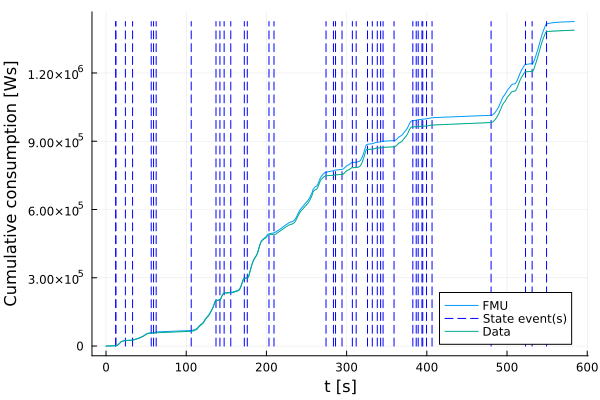

In [8]:
# load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2022x)
fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME, logLevel=:info)  # "Log everything that might be interesting!", default is `:warn`

# let's have a look on the model meta data
fmiInfo(fmu)

# let's run a simulation from `tStart` to `tStop`, use the parameters we just viewed for the simulation run
resultFMU = fmiSimulate(fmu, (tStart, tStop); parameters=data.params, showProgress=showProgress)
display(resultFMU)

fig = plot(resultFMU)                                                                        # Plot it, but this is a bit too much, so ...
fig = plot(resultFMU; stateIndices=6:6)                                                      # ... only plot the state #6 and ...
fig = plot(resultFMU; stateIndices=6:6, ylabel="Cumulative consumption [Ws]", label="FMU")   # ... add some helpful labels!

# further plot the (measurement) data values `consumption_val` and deviation between measurements `consumption_dev`
plot!(fig, data.cumconsumption_t, data.cumconsumption_val; label="Data", ribbon=data.cumconsumption_dev, fillalpha=0.3)

We do another simulation run and record the derivative values, to have a good starting point for scaling the pre- and post-processing layers. Finally, the FMU is unloaded again to release memory.

In [9]:
# variable we want to manipulate - why we are picking exactly these three is shown a few lines later ;-)
manipulatedDerVars = ["der(dynamics.accelerationCalculation.integrator.y)",
                      "der(dynamics.accelerationCalculation.limIntegrator.y)",
                      "der(result.integrator.y)"]
# alternative: manipulatedDerVars = fmu.modelDescription.derivativeValueReferences[4:6]

# reference simulation to record the derivatives 
resultFMU = fmiSimulate(fmu, (tStart, tStop), parameters=data.params, recordValues=:derivatives, saveat=tSave, showProgress=showProgress) 
manipulatedDerVals = fmiGetSolutionValue(resultFMU, manipulatedDerVars)

# what happens without propper transformation between FMU- and ANN-domain?
plot(resultFMU.values.t, manipulatedDerVals[1,:][1]; label="vehicle velocity");
plot!(resultFMU.values.t, tanh.(manipulatedDerVals[1,:][1]); label="tanh(velocity)")

# unload FMU
fmiUnload(fmu)

## 3. NeuralFMU setup

In [10]:
function build_NFMU(f::FMU2)
    
    # pre- and post-processing
    preProcess = ShiftScale(manipulatedDerVals)
    preProcess.scale[:] *= 0.25 # add some additional "buffer"
    postProcess = ScaleShift(preProcess; indices=2:3) 

    # cache
    cache = CacheLayer()
    cacheRetrieve = CacheRetrieveLayer(cache)

    # the gates layer, signals are:
    # (1) acceleration from FMU (gate=1.0 | open)
    # (2) consumption  from FMU (gate=1.0 | open)
    # (3) acceleration from ANN (gate=0.0 | closed)
    # (4) consumption  from ANN (gate=0.0 | closed)
    # the acelerations [1,3] and consumptions [2,4] are paired
    gates = ScaleSum([1.0, 1.0, 0.0, 0.0], [[1,3], [2,4]]) 

    # setup the NeuralFMU topology
    net = Chain(x -> f(; x=x),                    # take `x`, put it into the FMU, retrieve `dx`
            dx -> cache(dx),                    # cache `dx`
            dx -> dx[4:6],                      # forward only dx[4, 5, 6]
            preProcess,                         # pre-process `dx`
            Dense(3, 32, tanh),                 # Dense Layer 3 -> 32 with `tanh` activasion
            Dense(32, 2, tanh), # 32, 1, tanh                # Dense Layer 32 -> 1 with `tanh` activasion 
            postProcess,                        # post process `dx`
            dx -> cacheRetrieve(5:6, dx),  # 5:5     # dynamics FMU | dynamics ANN
            gates,                              # compute resulting dx from ANN + FMU
            dx -> cacheRetrieve(1:4, dx)) # (1:4, dx, 6:6) # stack together: dx[1,2,3,4] from cache + dx from ANN + dx[6] from cache

    # new NeuralFMU 
    neuralFMU = ME_NeuralFMU(f, net, (tStart, tStop); saveat=tSave)
    neuralFMU.modifiedState = false # speed optimization (no ANN before the FMU)
    
    return neuralFMU 
end

build_NFMU (generic function with 1 method)

Let's test the NeuralFMU.

In [12]:
# load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2022x)
fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME)

# build NeuralFMU
neuralFMU = build_NFMU(fmu)

# get start state vector from data (FMIZoo)
x0 = FMIZoo.getStateVector(data, tStart)

########

# simulate and plot the (uninitialized) NeuralFMU
resultNFMU = neuralFMU(x0, (tStart, tStop); parameters=data.params, showProgress=showProgress) 
display(resultNFMU_original)

# plot the NeuralFMU, original FMU and data (velocity)
fig = plot(resultNFMU; stateIndices=5:5, label="NeuralFMU (original)", ylabel="velocity [m/s]")
plot!(fig, resultFMU; stateIndices=5:5, values=false, stateEvents=false)
plot!(fig, data.speed_t, data.speed_val, label="Data")

# plot the NeuralFMU, original FMU and data (cumulative consumption)
fig = plot(resultNFMU; stateIndices=6:6, stateEvents=false, timeEvents=false, label="NeuralFMU (original)", ylabel="velocity [m/s]")
plot!(fig, resultFMU; stateIndices=6:6, values=false, stateEvents=false, timeEvents=false, label="FMU")
plot!(fig, data.cumconsumption_t, data.cumconsumption_val, label="Data")

# unload FMU / invalidate NeuralFMU
fmiUnload(fmu)
neuralFMU = nothing

Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 351551
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂x: 0
	∂y_∂u: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 705849
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 0
	Steps completed: 58440
States [5838]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	0.1	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 14.260000000955804]
	0.2	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 28.52000000095581]
	0.3	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 42.78000000095581]
	0.4	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 57.04000000095582]
	0.5	[-1.0313822985067192e-

┌ Info: fmi2Load(...): FMU resources location is `file:///C:/Users/thummeto/AppData/Local/Temp/fmijl_am6yw6/VLDM/resources`
└ @ FMICore C:\Users\thummeto\Documents\FMICore.jl\src\logging.jl:21


┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:106
┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:106


## 4. Training the NeuralFMU

In [13]:
# prepare training data 
train_t = data.consumption_t 

# data is as "array of arrays" required (multidimensional data)
train_data = collect([d] for d in data.cumconsumption_val)

5838-element Vector{Float64}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   ⋮
 582.9
 583.0
 583.1
 583.2
 583.3
 583.4
 583.5
 583.6
 583.7

Next, the loss function is defined. The loss is computed on basis of a given `solution` and `data`. Dependent on the hyperparameter `LOSS`, either `:MAE` or `:MSE` is used to compute the loss. 

In [14]:
function _lossFct(solution::FMU2Solution, data::VLDM_Data, LOSS::Symbol)

    if !solution.success
        @warn "The solution process was not successfull, try to compute loss anyway."
    end

    ts = 1+round(Int, solution.states.t[1]/dt)
    te = 1+round(Int, solution.states.t[end]/dt)
    
    nfmu_cumconsumption = fmiGetSolutionState(solution, 6; isIndex=true)
    cumconsumption = data.cumconsumption_val[ts:te]
    cumconsumption_dev = data.cumconsumption_dev[ts:te]

    Δcumconsumption = 0.0
    if LOSS == :MAE
        Δcumconsumption = FMIFlux.Losses.mae_dev(nfmu_cumconsumption, cumconsumption, cumconsumption_dev)
    elseif LOSS == :MSE
        Δcumconsumption = FMIFlux.Losses.mse_dev(nfmu_cumconsumption, cumconsumption, cumconsumption_dev)
    else
        @assert false, "Unknown LOSS: `$(LOSS)`"
    end
    
    return Δcumconsumption 
end

_lossFct (generic function with 1 method)

Finally, the function `train!` is defined, that triggers a new training run for a given set of hyperparameters `hyper_params`, a training ressource `ressource` and the current training index `ind`. The following hyperparameters are used:
- `TRAINDUR` equals the given `ressource` and specifies the training duration (meassured on data) in seconds
- `ETA` the update rate $\eta$ of the *Adam* optimizer
- `BETA1` the first momentum coefficient $\beta_1$ of the *Adam* optimizer 
- `BETA2` the second momentum coefficient $\beta_2$ of the *Adam* optimizer 
- `BATCHDUR` the duration of a single batch element (length) in seconds
- `LASTWEIGHT` a weighting factor between the last solution point and all remaining solution points (a value of $0.7$ determines that the last point of the solution contributes $70\%$ to the loss, whereas all remaining solution points only contribute $30\%$ in total)
- `SCHEDULER` an identifier for the batch scheduler, can be `:Sequential`, `:Random` or `:LossAccumulation`
- `LOSS` an identifier for the loss function to use, `:MAE` or `:MSE`

In [18]:
# ressource = training time horizon (duration of data seen)
function train!(hyper_params, ressource, ind)

    # make the runs determinisitic by fixing the random seed
    Random.seed!(1234)

    TRAINDUR = ressource
    ETA, BETA1, BETA2, BATCHDUR, LASTWEIGHT, SCHEDULER, LOSS = hyper_params
    steps = max(round(Int, TRAINDUR/BATCHDUR), 1) 

    @info "--------------\nStarting run $(ind) with parameters: $(hyper_params) and ressource $(ressource) doing $(steps) step(s).\n--------------------"

    # load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2020x)
    # `:info` means to log everything that might be interesting, default is `:warn`
    fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME) 

    neuralFMU = build_NFMU(fmu)

    # switch to a more efficient execution configuration, allocate only a single FMU instance, see:
    # https://thummeto.github.io/FMI.jl/dev/features/#Execution-Configuration
    fmu.executionConfig = FMI.FMIImport.FMU2_EXECUTION_CONFIGURATION_NOTHING
    c, _ = FMIFlux.prepareSolveFMU(neuralFMU.fmu, nothing, neuralFMU.fmu.type, true, false, false, false, true, data.params; x0=x0)

    # batch the data (time, targets), train only on model output index 6, plot batch elements
    batch = batchDataSolution(neuralFMU, t -> FMIZoo.getStateVector(data, t), train_t, train_data;
        batchDuration=BATCHDUR, indicesModel=6:6, plot=false, parameters=data.params, showProgress=showProgress) # try `plot=true` to show the batch elements, try `showProgress=true` to display simulation progress

    # limit the maximum number of solver steps to 1e5 and maximum simulation/training duration to 30s
    solverKwargsTrain = Dict{Symbol, Any}(:maxiters => round(Int, 100*BATCHDUR*10)) # , :max_execution_duration => BATCHDUR*10.0) # , :dtmin => 1e-6) # , :max_execution_duration => 60.0)
    # for dt=10.0s, this equals 10 000 steps per second and 

    # picks a modified MSE, which weights the last time point MSE with 25% and the remaining element MSE with 75%
    # this promotes training a continuous function, even when training on batch elements
    lossFct = (solution::FMU2Solution) -> _lossFct(solution, data, LOSS)

    scheduler = nothing
    if SCHEDULER == :Random
        scheduler = RandomScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :Sequential
        scheduler = SequentialScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :LossAccumulation
        scheduler = LossAccumulationScheduler(neuralFMU, batch, lossFct; applyStep=1, plotStep=0, updateStep=1)
    else 
        @error "Unknown SCHEDULER: ´$(SCHEDULER)´."
        return nothing
    end
    updateScheduler = () -> update!(scheduler)

    # loss for training, take element from the worst element scheduler
    loss = p -> FMIFlux.Losses.loss(neuralFMU, batch; 
        p=p, parameters=data.params, lossFct=lossFct, batchIndex=scheduler.elementIndex, logLoss=true, showProgress=showProgress, solverKwargsTrain...) # try `showProgress=true` to display simulation progress

    # gather the parameters from the NeuralFMU
    params = FMIFlux.params(neuralFMU)

    # initialize the scheduler 
    initialize!(scheduler; parameters=data.params, p=params[1], showProgress=showProgress)
    
    optim = Adam(ETA, (BETA1, BETA2))
   
    FMIFlux.train!(loss, params, Iterators.repeated((), steps), optim; gradient=:ForwardDiff, chunk_size=32, cb=updateScheduler, proceed_on_assert=true) 
    
    fmu.executionConfig = FMI.FMIImport.FMU2_EXECUTION_CONFIGURATION_NO_RESET
    FMIFlux.finishSolveFMU(neuralFMU.fmu, c, false, true)

    fmiSaveParameters(neuralFMU, joinpath(@__DIR__, "params", "$(HPRUN)", "$(ind).jld2"))

    validation_NFMU = nothing
    
    # loss on validation loss!
    resultNFMU = neuralFMU(x0, (data_validation.consumption_t[1], data_validation.consumption_t[end]); parameters=data_validation.params, showProgress=showProgress, maxiters=1e7, saveat=data_validation.consumption_t) 
    if resultNFMU.success
        validation_NFMU = _lossFct(resultNFMU, data_validation, :MSE)
    end        

    fmiUnload(fmu)

    return validation_NFMU
end

train! (generic function with 1 method)

Let's check if the train function is working for a given set of hyperparameters.

In [19]:
# check if the train function is working for a set of given hyperparameters
#     ([ETA,  BETA1, BETA2, BATCHDUR, LASTWEIGHT,       SCHEDULERID, LOSS], RESSOURCE, INDEX)
train!([1e-4,   0.9, 0.999,      3.0,        0.7, :LossAccumulation, :MAE],       3.0,     1)

┌ Info: --------------
│ Starting run 1 with parameters: Any[0.0001, 0.9, 0.999, 3.0, 0.7, :LossAccumulation, :MAE] and ressource 3.0 doing 1 step(s).
│ --------------------
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:11
┌ Info: AVG: 6.40e+01 | MAX: 1.17e+03 @ #0
└ @ FMIFlux C:\Users\thummeto\Documents\FMIFlux.jl\src\scheduler.jl:366


┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tuple{}, Tuple{}, Tuple{}, NamedTuple{(:shift, :scale), Tuple{Int64, Int64}}, NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}, NamedTuple{(:weight, :bia

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tup

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tup

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tup

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tup

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Warning: dt(Dual{ForwardDiff.Tag{var"#56#60"{var"#54#58"{Symbol}, Dict{Symbol, Any}, Vector{FMIFlux.FMU2SolutionBatchElement}, ME_NeuralFMU{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, Vector{Float64}, Optimisers.Restructure{Chain{Tuple{var"#33#38"{FMU2}, var"#34#39"{CacheLayer}, var"#35#40", ShiftScale{Float64}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, ScaleShift{Float64}, var"#36#41"{CacheRetrieveLayer}, ScaleSum{Float64}, var"#37#42"{CacheRetrieveLayer}}}, NamedTuple{(:layers,), Tuple{Tuple{Tup

┌ Warning: The solution process was not successfull, try to compute loss anyway.
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:4
┌ Info: AVG: 6.40e+01 | MAX: 1.17e+03 @ #61
└ @ FMIFlux C:\Users\thummeto\Documents\FMIFlux.jl\src\scheduler.jl:366


9.113091082665724e9

## Results Discussion

In [ ]:
validate()

# Optional: Organize as module
If you want, you can place all code inside of a module named `NODE_Training`, this simplifies hyper parameter optimization (if you want to do one).

In [ ]:
# for hyper parameter optimization, place the code in a `module`
# just uncomment the following line (and the one at the very beginning, too!) 
#end # NODE_Training 